## Inicializacao

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *

dataTank = pd.read_csv('data/coupletanks.csv')
u = np.reshape(np.array(dataTank['u']), (1,2401))
y = np.array(dataTank[['tank1', 'tank2']].T)

## Selecao de estrutura

In [2]:
output = 0
params = []
params.append({'nb':[2,2],'na':[12], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':8, 'diff':True})
params.append({'nb':[0,2],'na':[1], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':0})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])
#print(ss, ss.shape)

vCandidatos = sselector.matrix_candidate(u, y, **params[output])
#print(vCandidatos.shape)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[output, pad:], 3, 0.00001)
theta = LSM(y[output, pad:], psi)
model = ss[selected]
print(model, theta)

[Y1.1 U1.12 sqrtM(Y1.1)] [ 1.00029921  0.02485631 -0.04768864]


### Simulação

(2, 2401)
oneStepForward
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10, U1.11, U1.12]


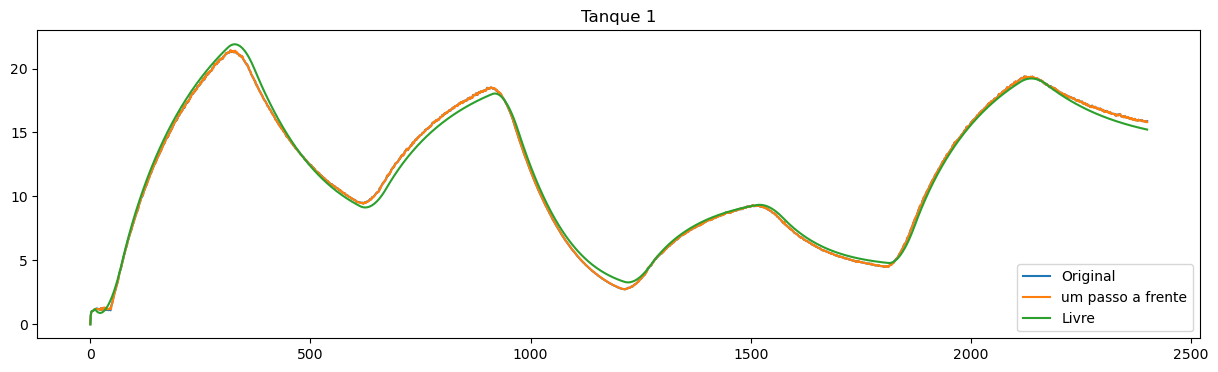

In [7]:
slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

plt.figure(figsize=(15,4))
plt.title("Tanque " + str(output+1))
plt.plot(y[output].T, label='Original')
plt.plot(yhat, label='um passo a frente')
plt.plot(slivre, label='Livre')
plt.legend()
plt.show()

## Validação

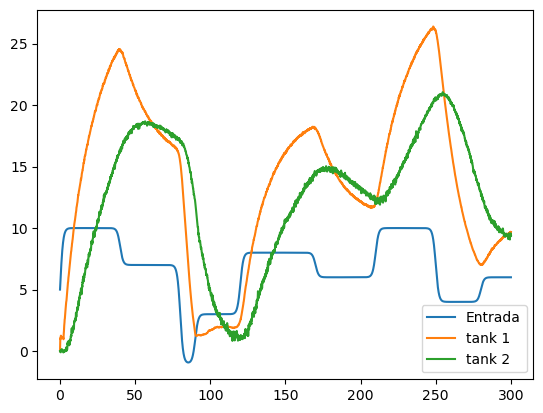

In [8]:
mat_content1 = sc.loadmat("data/ct1x1.mat")
mat_content2 = sc.loadmat("data/ct1x2.mat")

tanque1 = mat_content1['Tanque1']
tanque2 = mat_content2['Tanque2']

t1 = tanque1['time'][0][0]
v1 = tanque1['signals'][0][0]['values'][0][0]

t2 = tanque2['time'][0][0]
v2 = tanque2['signals'][0][0]['values'][0][0]

input = pd.read_csv('data/xinput.csv')
t = input['t']
uVal = np.array(input['v']).reshape((1,-1))

plt.plot(t, uVal.T, label='Entrada')
plt.plot(t1, v1, label="tank 1")
plt.plot(t2, v2, label="tank 2")
plt.legend()
plt.show()

(2, 3001)
(2, 3001)
oneStepForward
--------s:  [Y1.1, Y1.2, Y2.1, Y2.2, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10, U1.11, U1.12]
Modelo selecionado:
0.0248563094786356⋅U1.12 + 1.00029920714271⋅Y1.1 - 0.0476886357676283⋅sqrtM(Y1
.1)


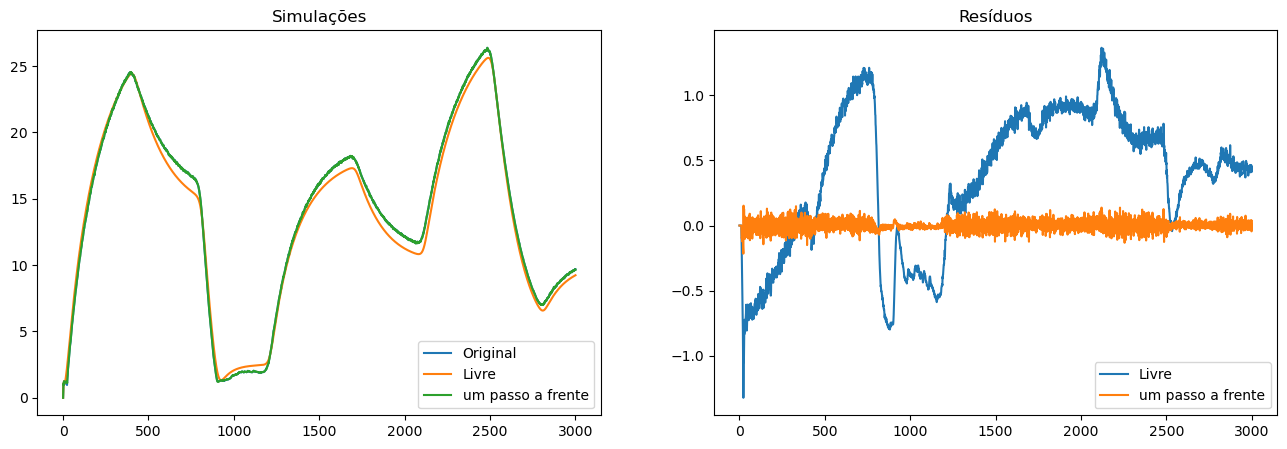

In [9]:
v1[v1 < 0] = 0
v2[v2 < 0] = 0
v2[:100] = 0
yVal = np.vstack((v1.T, v2.T))
print(yVal.shape)
z = np.zeros(yVal.shape)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(1,2, figsize=[16,5])

ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(valLivre, label='Livre')
ax[0].plot(yhat, label='um passo a frente')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - valLivre, label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

In [ ]:
def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))), 5)
    print('MSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')
    cc = np.corrcoef(y, yest)
    #print("Correlation pearson:", np.mean(cc))

print("\nSimulação livre")
metrics(yVal[output], valLivre)
print("\nUm passo a frente")
metrics(yVal[output], yhat)

# tank

In [ ]:
tank = pd.read_csv('data/dataBenchmark.csv')
print(tank.keys(), tank.Ts.shape)
p = {'nb':[2],'na':[2], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':0, 'diff':False}
strucSelector = structureSelector()
s = strucSelector.symbolic_regressors(**p)
print(s)
f, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].plot(tank.uEst)
ax[0].plot(tank.yEst)
ax[1].plot(tank.uVal)
ax[1].plot(tank.yVal)
plt.show()

In [ ]:
yVal = np.array(tank.yVal).reshape((1,-1))
uVal = np.array(tank.uVal).reshape((1,-1))
yVal[yVal < 0] = 0

z = np.zeros(yVal.shape)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], p['nb'], p['na'], 0)
#yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)

'''print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(1,2, figsize=[16,5])

ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(valLivre, label='Livre')
ax[0].plot(yhat, label='um passo a frente')
ax[1].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - valLivre, label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()'''